In [30]:
%matplotlib inline
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import seaborn as sns
import usaddress
import datetime as dt

This "data science" mapping workbook is to look at 5 years of data for the City of Charlottesville for arrests as a measure of community - police interactions. This data and notebook should be readable/useable for most folks with some knowledge of mapping and/or programming.  Lots of comments should be in code to explained what/how something is being done.

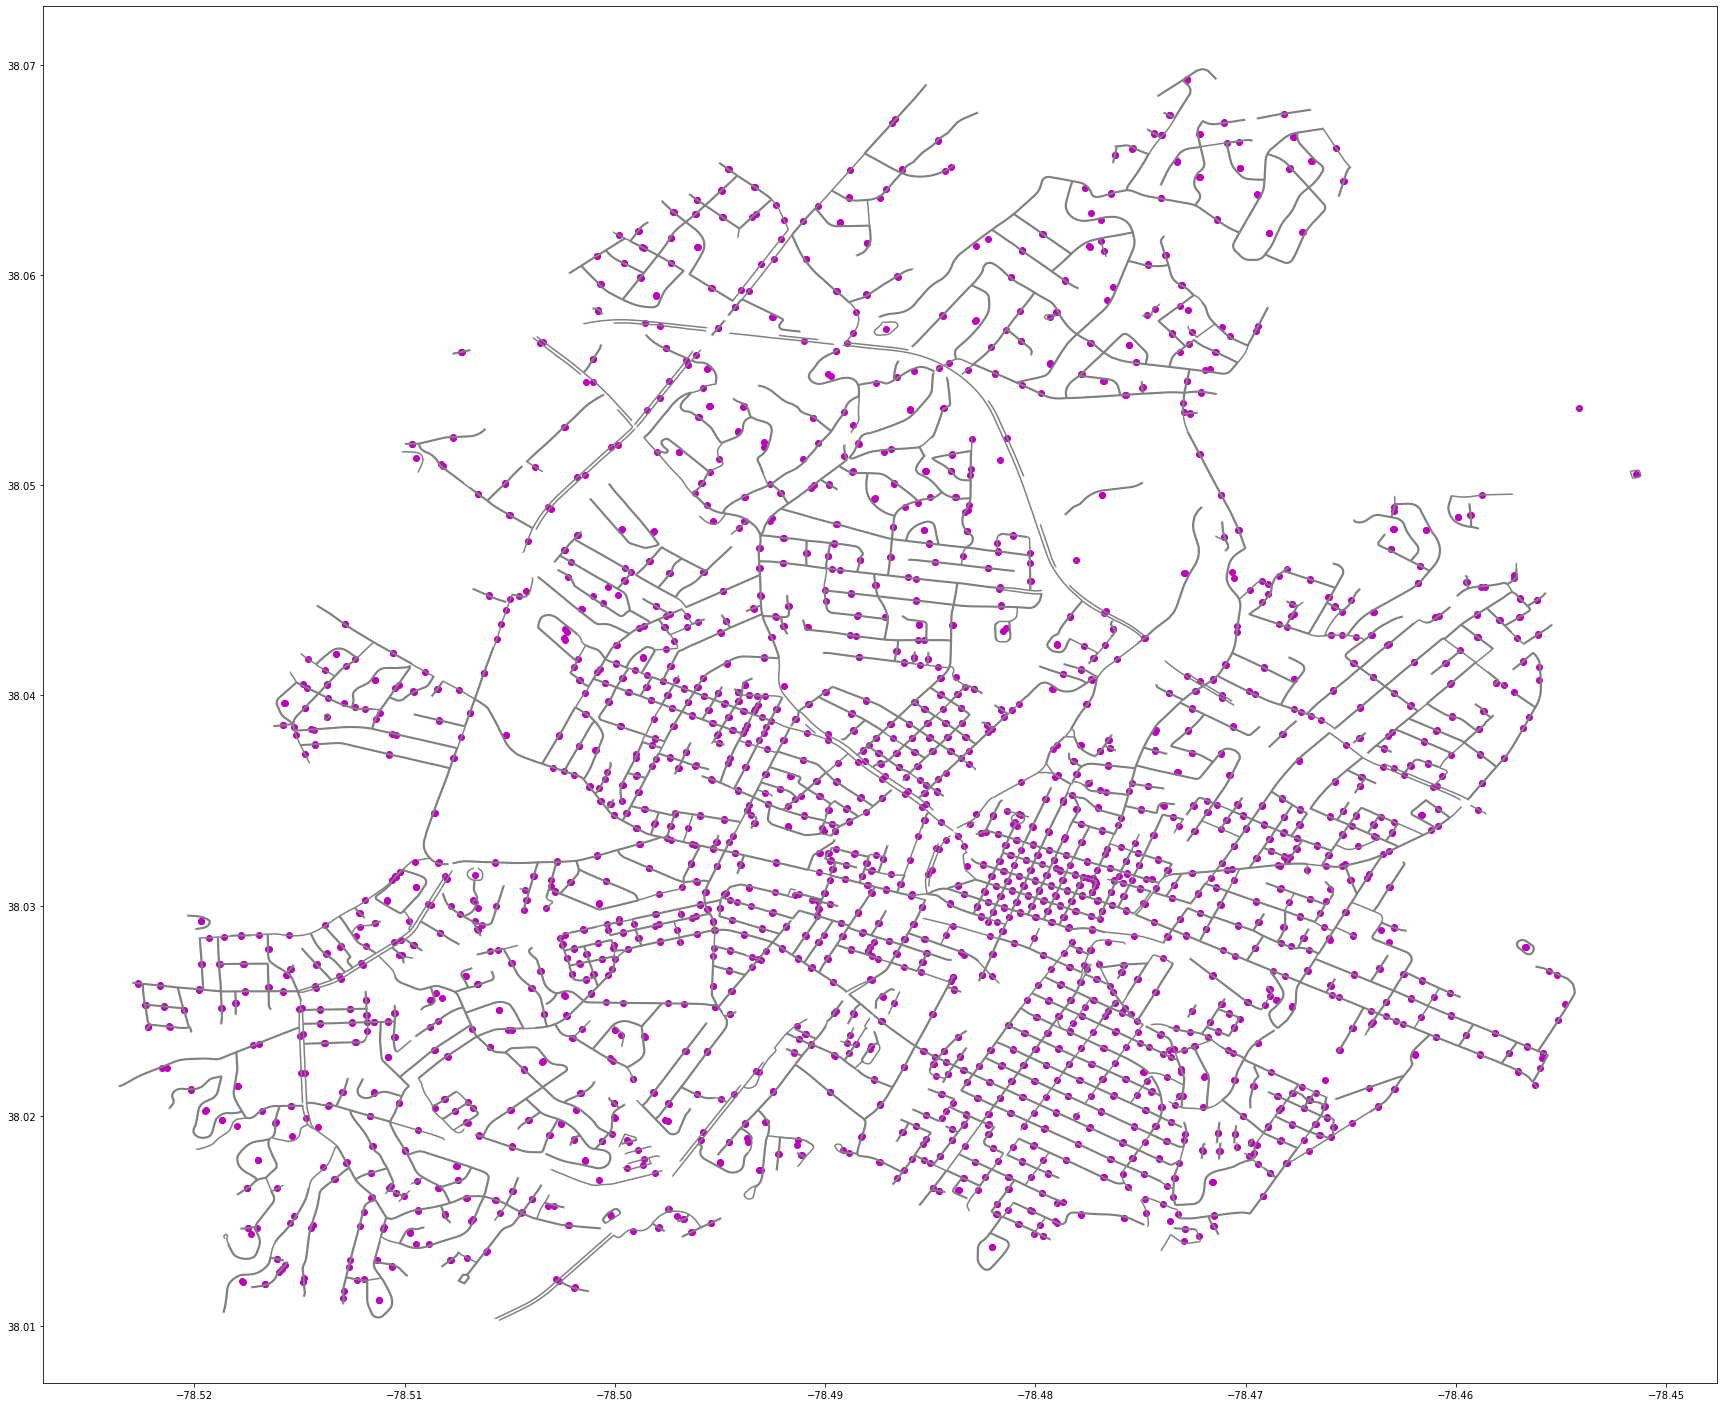

In [3]:
# read the file for roads in Cville that defines each block
cville_roads = gpd.read_file('https://opendata.arcgis.com/datasets/e5a3e226dd9d4399aa014858f489852a_60.geojson')

#print (cville_roads.crs)
# yay the result of that gives: epsg:4326! The open data geojson is in sensible projections, unlike the shapefile on the city's OpenData portal
# which is in epsg:2284 which is NAD 83/Virginia South measured in ft
# yay America and our non -adoption of the metric system!

# make a copy of file for the roads and centroid so you can have a single position for the block instead of the whole line
# that makes it easier to treat each arrest as a point and also to do things like slightly anonymize things on the block level
cville_road_centroids = cville_roads.copy()
cville_road_centroids['geometry'] = cville_road_centroids['geometry'].centroid

# Eventually we're going to need to match arrests to street address to make a pretty map, so we need to combine block number and Street name
cville_road_centroids['blockstreet'] = cville_road_centroids['Block']+' '+cville_road_centroids['Street']

#behold a grid system! Kinda. This place is historical we don't believe in no pure grids. Anyhow, cville_roads will be the road paths in grey (color='0.5')
# the block centroids will be in magenta (color='m')
fig,ax = plt.subplots(figsize=(30,30))
cville_roads.plot(ax=ax, color='0.5')
cville_road_centroids.plot(ax=ax, color='m')
plt.show()

figuring out what data we want in the end:
 1: I want to map every unique arrest in town over five years.
 2: I want to map every unique arrest in town over five years as a function of race: is everyone getting arrested everywhere or are certain groups getting arrests in one place
 3: I want to map arrests by Statute : for example, where are people being arrested for public drunkeness? 
 4: I want to look at arrests by Statute: if someone is arrested for public drunkness, how many other charges are added onto that arrest? What's the breakdown btwn black and white folks? 
 5: In the end: if I map unique arrests vs "crime calls" : is there an overdensity of arrests that would suggest unequal enforcement?
 
 
To address 1 and 2: need to take the list of all arrests which break things down to one line per person, per date-time per charge and do something so we have :
Name and date for each line, then make new table which a) counts how many entries have the same name and date to count the number of violations assessed at once, b) records a block level address for the arrests and c) records the racial data for that person, d) along with block level address I then want latitude/longitude to make the map

For three: I need the list of all arrests so then I can parse the table to return just the lines of desired arrest type and map them. Also need to use block address to get latitude/longitdue

For 4: I need no mapping! Just name and date-time and race for all charges

for 5: I will eventually want the data for 1 and 2 with unique arrests and also read in the crime data and make a map from that

Index(['ArrestID', 'ArrestDatetime', 'FirstName', 'HouseNumber', 'LastName',
       'MiddleName', 'NameSuffix', 'Statute', 'StatuteDescription', 'Street',
       'Race', 'Sex', 'geometry'],
      dtype='object')
There are this many different arrest types in C'ville: 547
There are this many different arrests types in C'ville where more than 20 arrests have happened: 109


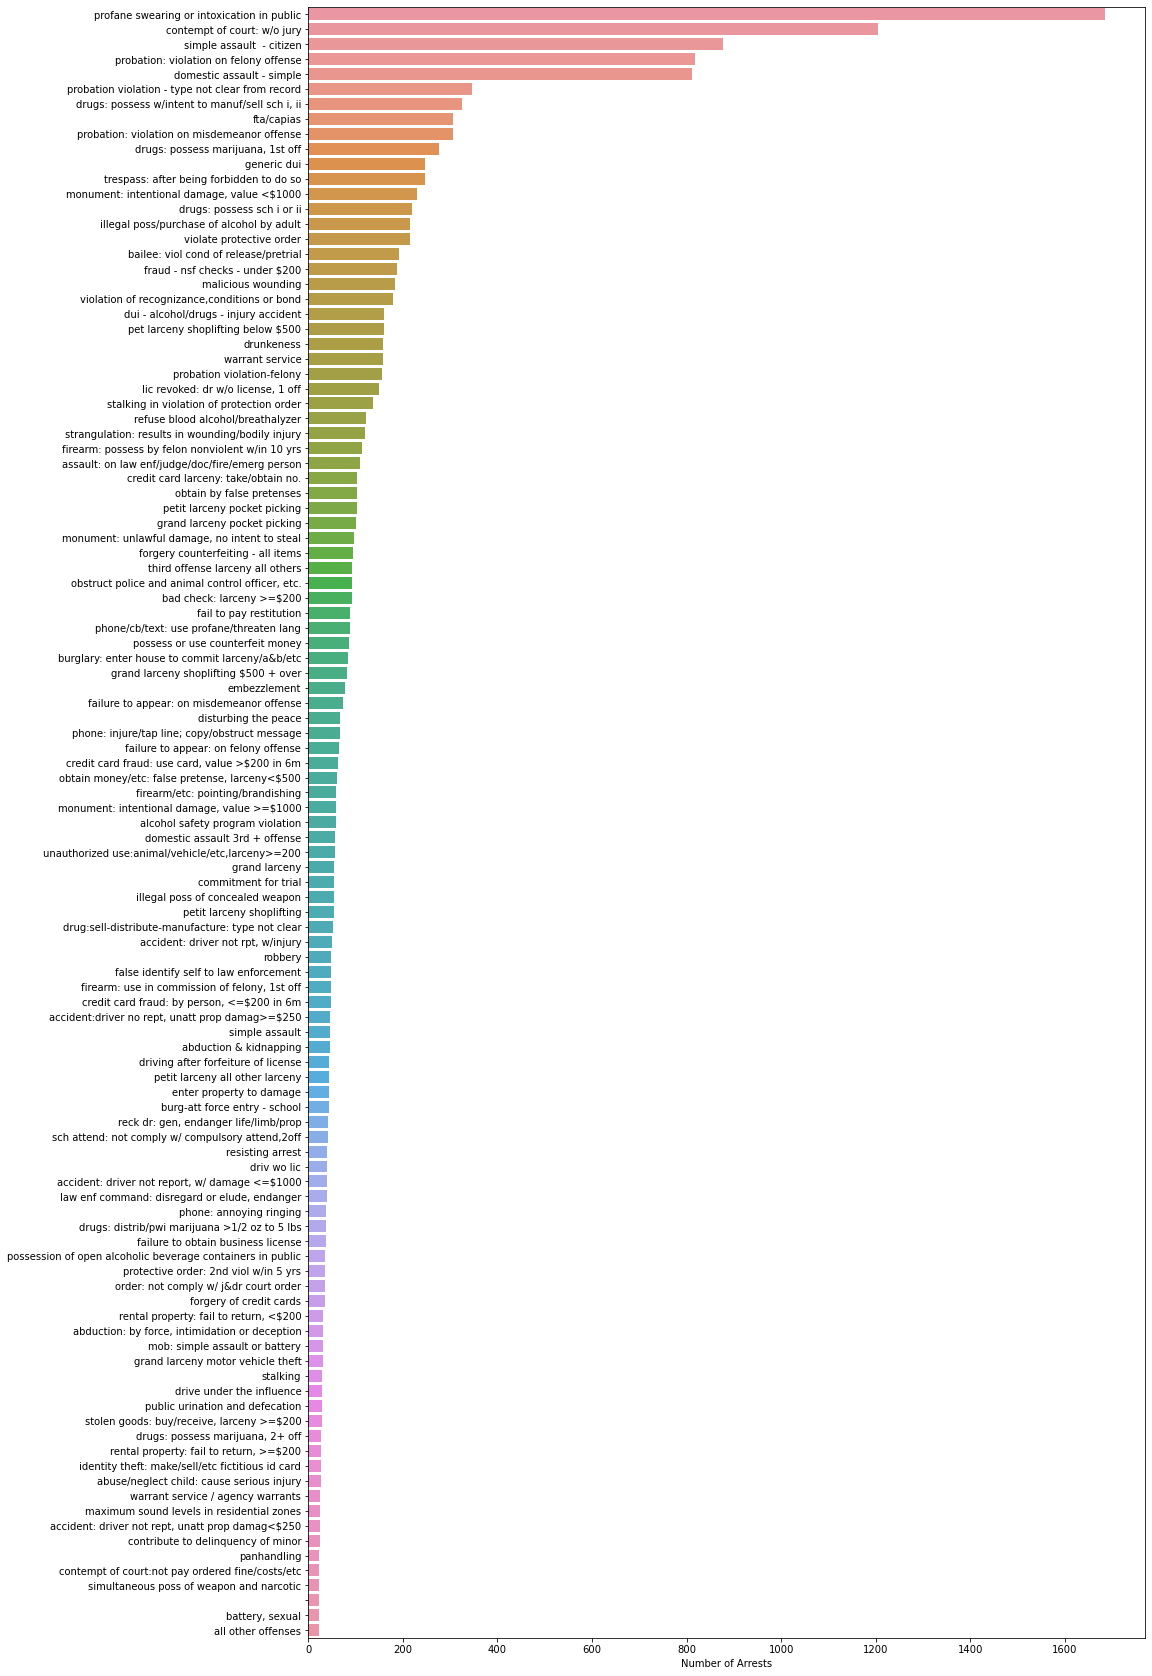

In [112]:

# read the arrests data from the city's depository
arrests = gpd.read_file('https://opendata.arcgis.com/datasets/d558ab0e09fe4f509280bedf6f8793ed_22.geojson')
# make a copy of arrests just for mapping
arrests_mapping = arrests.copy()


# now go back to fiddling with arrests for number 4, let's remind ourselves what all the columns are here
print (arrests.columns)


# okay for our just looking at distributions of arrests by race and gender the following columns are useless:
# ArrestID, HouseNumber, Street, geometry so let's drop those (columns are axis =1 ) and we want the drop to happen in place, which means the table will be forever modified
arrests.drop(['ArrestID', 'HouseNumber','Street','geometry'], axis=1, inplace=True)

# now make it easy to match all the Statutes we need them to be the same letter case, so change them all to lower case
arrests['StatuteDescription'] =arrests['StatuteDescription'].str.lower()

# make a plot of all the arrest types and how often they've happened

arrest_counts = arrests.StatuteDescription.value_counts()
print ("There are this many different arrest types in C'ville:", len(arrest_counts))

#okay so there are 550 different types of arrests in Cville. That's a bunch! What happens if we limit that to thin gs more than 20 arrests have been made for?

print ("There are this many different arrests types in C'ville where more than 20 arrests have happened:",len(arrest_counts[arrest_counts > 20]))

# okay, so 109 charges where people have been arrested at least 20 times, that's better. Let's make a bar graph!
# we're going to make a barplot with seaborn (sns)

fig, ax = plt.subplots(figsize=(15,30))
sns.barplot(x=arrest_counts[arrest_counts > 20], y=arrest_counts[arrest_counts > 20].index, ax=ax)
plt.xlabel('Number of Arrests')
plt.show()




The unique genders are: ['Male' 'Female' None 'Unknown']
The gender counts are: Male       12740
Female      3615
Unknown        1
Name: Sex, dtype: int64
The unique races are: ['Black' 'White' 'nwt' None 'Unknown' 'American Indian/Alaskan Native'
 'Asian or Pacific Islander' 'doc' 'jpg']
The race counts are: Black                             8868
White                             7205
Asian or Pacific Islander          104
Unknown                             86
nwt                                 53
doc                                 19
American Indian/Alaskan Native      13
jpg                                  2
Name: Race, dtype: int64
I estimate there are about  110  Latinx folks not properly categorized


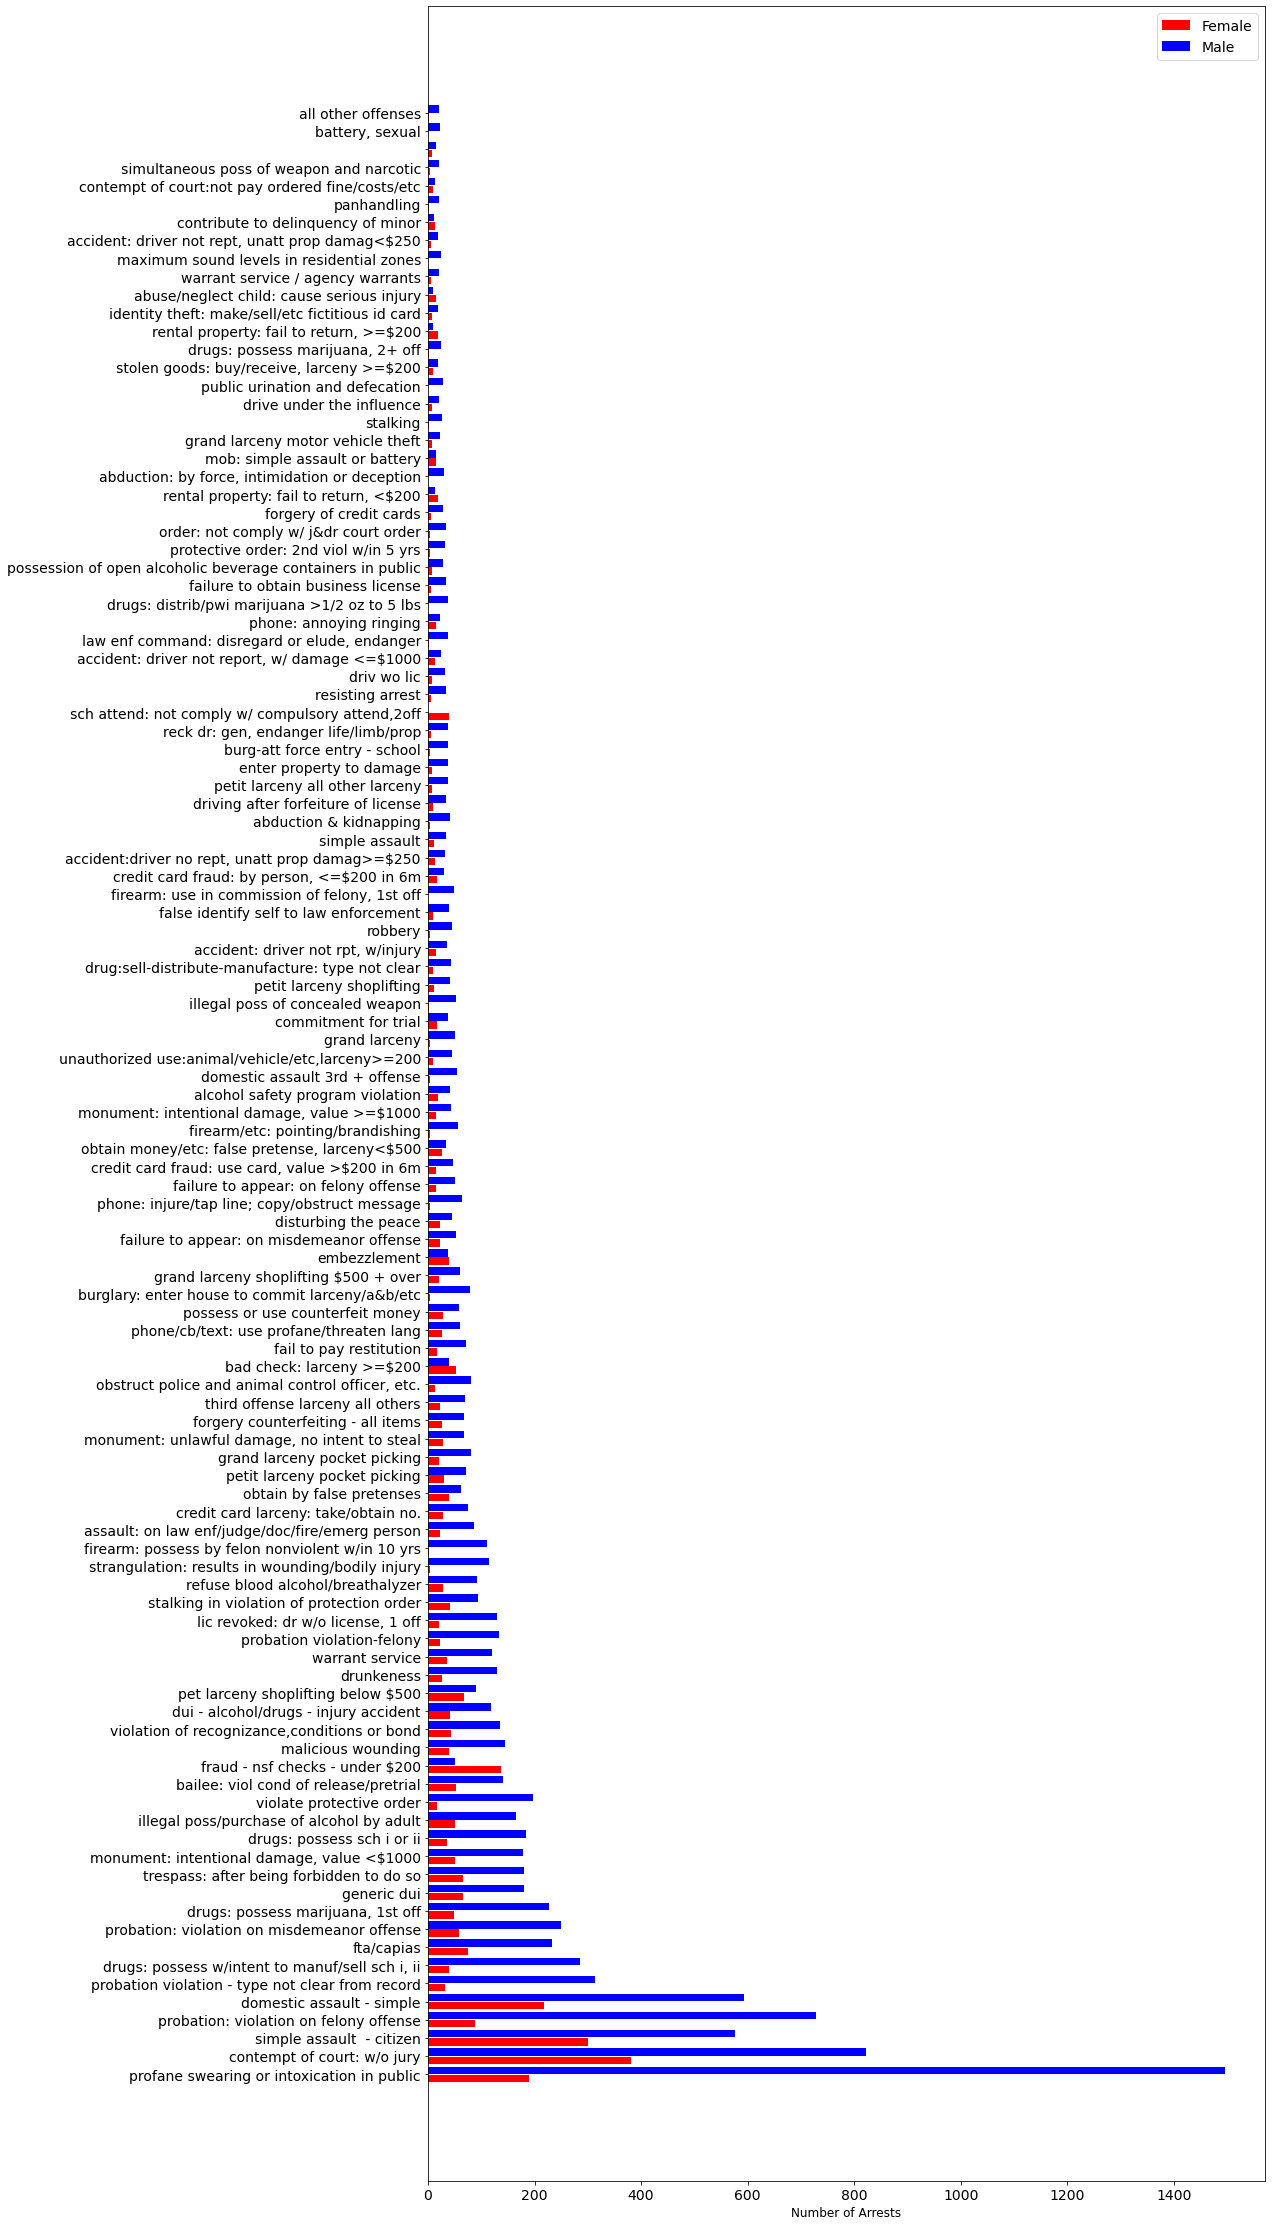

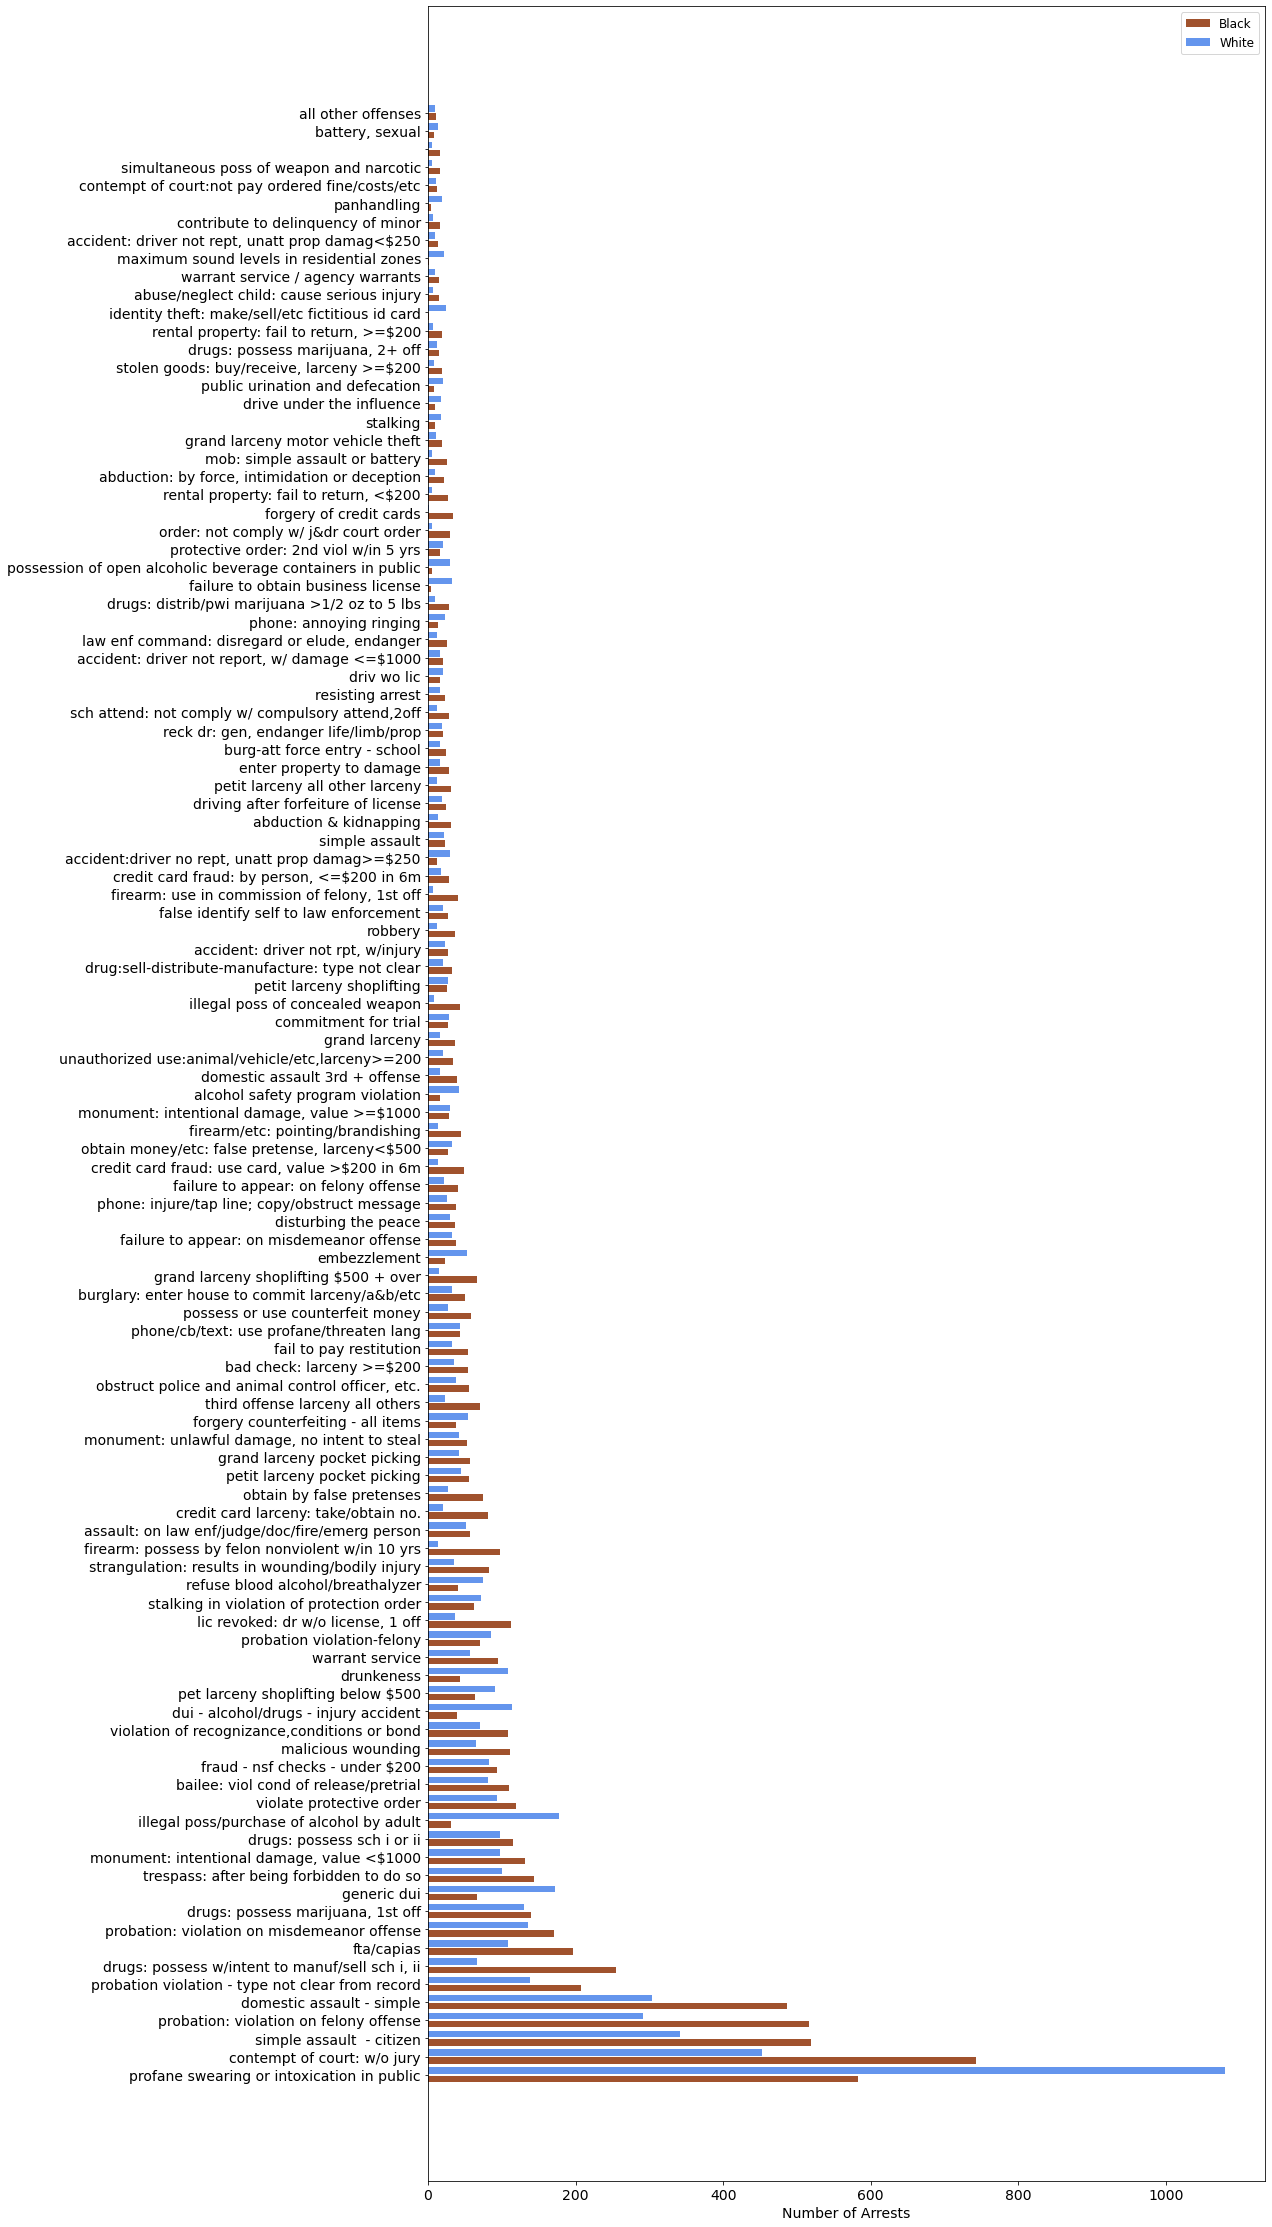

In [168]:
# now do something to try and split the arrests data: try by gender and race. Let's double check the unique genders and races that exist in the data
print ('The unique genders are:', arrests.Sex.unique())
print ('The gender counts are:', arrests.Sex.value_counts())
print ('The unique races are:', arrests.Race.unique())
print ('The race counts are:', arrests.Race.value_counts())



# so....the unique races show that the Cville police are not keeping good records and/or need some more training on accurate recording of racial or ethnicity background
# I'm just going to do a kinda crappy estimate of how many of the folks labeled as White may well be Latinx
# I say this is a crappy estimate b/c I'm going to use the 2010 Census and from the top 50 US Surnames, pull out all of those where > 90% are Hispanic
# origin of the census data is here: https://www2.census.gov/topics/genealogy/2010surnames/surnames.pdf in Table 1-A (page 8)
# change all the last names to lowercase from the table to match the list too just to get some counts

hispanic = ['garcia', 'rodriguez', 'martinez', 'hernandez', 'lopez', 'gonzalez', 'perez', 'sanchez', 'ramirez', 'torres', 'flores', 'rivera']
arrests['LastName']= arrests['LastName'].str.lower()


# look at last names, check to see if any given last name is in Hispanic and return True/False, then make count of False and True
# return count of True to estimate how many of the most frequent Hispanic names are in the arrest record and likely misclassified
latinx = arrests['LastName'].isin(hispanic)
latinx_count = latinx[latinx == True].count()
print ('I estimate there are about ', latinx_count, ' Latinx folks not properly categorized')


female = arrests[arrests.Sex == 'Female']
male = arrests[arrests.Sex == 'Male']
white = arrests[arrests.Race == 'White']
black = arrests[arrests.Race == 'Black']

# now for the most frequent charges I want to see how often men and women are arrested and how often whites and blacks are arrested for each charge
most_freq_charges = list(arrest_counts[arrest_counts > 20].index)

f_count = []
m_count = []
w_count = []
b_count = []


for charge in most_freq_charges:
    f_count.append(len(female[female.StatuteDescription == charge]))
    m_count.append(len(male[male.StatuteDescription == charge]))
    w_count.append(len(white[white.StatuteDescription == charge]))
    b_count.append(len(black[black.StatuteDescription == charge]))

    
ind = np.arange(len(most_freq_charges))  # the x locations for the groups
 
    
# plot men v women    
    
fig,ax= plt.subplots(figsize=(15,40))
ax.barh(ind - 0.45/2,f_count, color='Red', height=0.4, label='Female')
ax.barh(ind + 0.45/2,m_count, color='Blue', height=0.4, label='Male')
ax.set_yticks(ind)
ax.set_yticklabels(most_freq_charges, fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.xlabel('Number of Arrests', fontsize=12)
plt.show()


# plot Black vs White

fig,ax= plt.subplots(figsize=(15,40))
ax.barh(ind - 0.45/2,b_count, color='sienna',  height=0.35, label='Black')
ax.barh(ind + 0.45/2,w_count, color='cornflowerblue', height=0.35, label='White')
ax.set_yticks(ind)
ax.set_yticklabels(most_freq_charges, fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
plt.legend(fontsize=12)
plt.xlabel('Number of Arrests', fontsize=14)
plt.show()

Okay, so those counts were each arrest charge. When we look at gender, there are 8 charges where more women have been charged than men: 
1. Fraud, non sufficient funds check, under \$200
1. Bad check, larcency >= \$200
1. Abuse/neglect child : cause serious injury
1. Rental property: fail to return >= \$200
1. School attendance: Not complying with compulsory attendance, 2nd offense
1. Rental property: fail to return < \$200
1. Embezzlement
1. Contributing to the delinquency of a minor

When comparing by race:
White people are drunks.


Next question becomes: if I collapse all the arrests down to one person and one date and hour, what happens? Are charges getting piled up disproportionally?

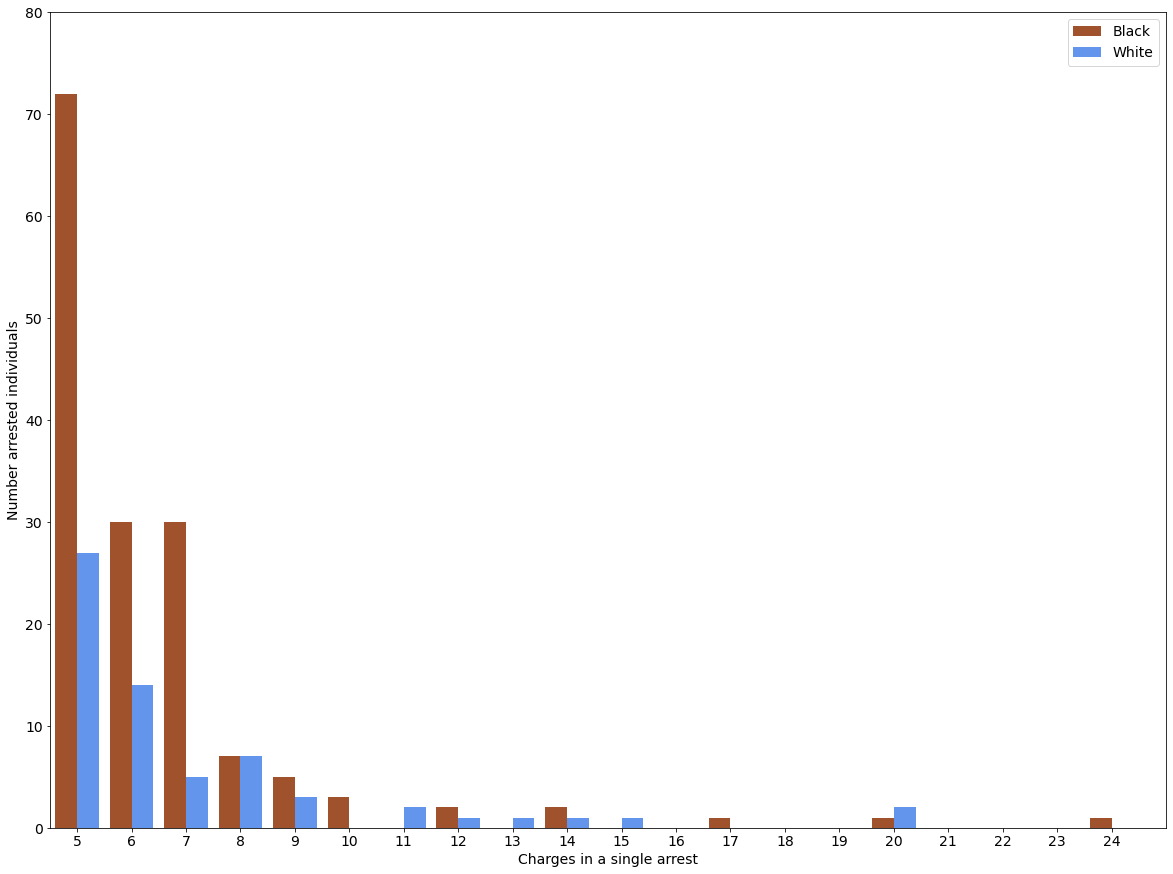

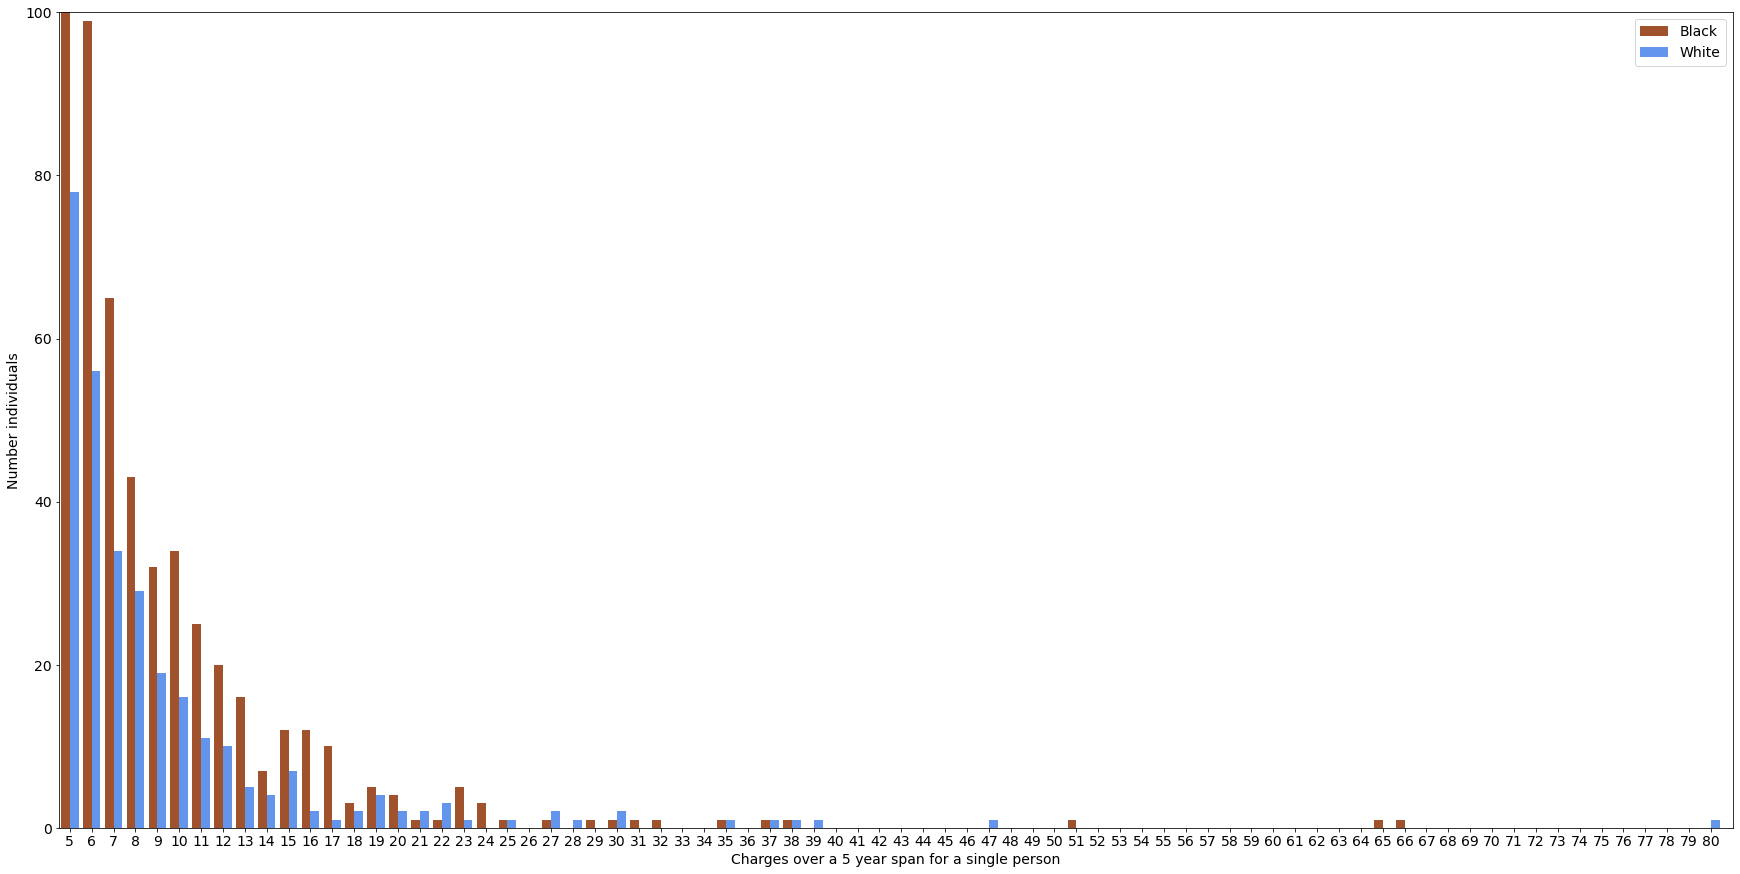

In [175]:
# make the arrests date time a real date and time object, and then make it just day and hour on the 24 hr clock
arrests['rounded_datetime'] = pd.to_datetime(arrests['ArrestDatetime']).dt.strftime('%Y-%m-%d %H')
# make a column that is a combo of name and date
arrests['name_and_date'] = arrests.FirstName.str.lower()+' '+arrests.MiddleName.str.lower()+' '+arrests.LastName+' '+arrests.rounded_datetime
arrests['fullname'] = arrests.FirstName.str.lower()+' '+arrests.MiddleName.str.lower()+' '+arrests.LastName

arrests.dropna(subset=['name_and_date'], inplace=True)



# look at one time arrests: how many charges get piled onto a single arrest as a function of race?
# using .value_counts() on name_and_date would probably make sense here, but since I'm just looking to merge things into a dataframe again
# and the file isn't that big, I shall do a janky loop

singleton_counts = []
singleton_race = []



for singleton in arrests.name_and_date.unique():
    this_person = arrests[arrests.name_and_date == singleton]
    singleton_counts.append(len(this_person))
    singleton_race.append(this_person.Race.values[0])

black = np.where(np.array(singleton_race) == 'Black')
white = np.where(np.array(singleton_race) == 'White')
singleton_counts = np.array(singleton_counts)

bins = np.arange(0, singleton_counts.max() + 1.5) - 0.5

plt.figure(figsize=(20,15))
plt.hist([singleton_counts[black], singleton_counts[white]], bins=bins, label=['Black', 'White'], color=['sienna', 'cornflowerblue'])
plt.xlim(4.5,np.max(singleton_counts)+1)
plt.yticks(fontsize=14)
plt.xticks(range(5,np.max(singleton_counts)+1),fontsize=14)
plt.xlabel('Charges in a single arrest', fontsize=14)
plt.ylabel('Number arrested individuals', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,80)
plt.show()



# go thru people who have had more than 5 charges. what's the black to white ratio on total number of charges
overall_counts = []
overall_race = []

for allpeople in arrests.fullname.unique():
    one_person = arrests[arrests.fullname == allpeople]
    overall_counts.append(len(one_person))
    overall_race.append(one_person.Race.values[0])

black = np.where(np.array(overall_race) == 'Black')
white = np.where(np.array(overall_race) == 'White')
overall_counts = np.array(overall_counts)

bins = np.arange(0, overall_counts.max() + 1.5) - 0.5


plt.figure(figsize=(30,15))
plt.hist([overall_counts[black], overall_counts[white]], bins=bins, label=['Black', 'White'], color=['sienna', 'cornflowerblue'])
plt.xlim(4.5,np.max(overall_counts)+1)
plt.yticks(fontsize=14)
plt.xticks(range(5,np.max(overall_counts)+1),fontsize=14)
plt.xlabel('Charges over a 5 year span for a single person', fontsize=14)
plt.ylabel('Number individuals', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,100)
plt.show()

One last thing before mapping: Now that we have a breakdown of charges per single police interaction and total charges over 5 years, we also may want to know how often are individuals interacting with the cops

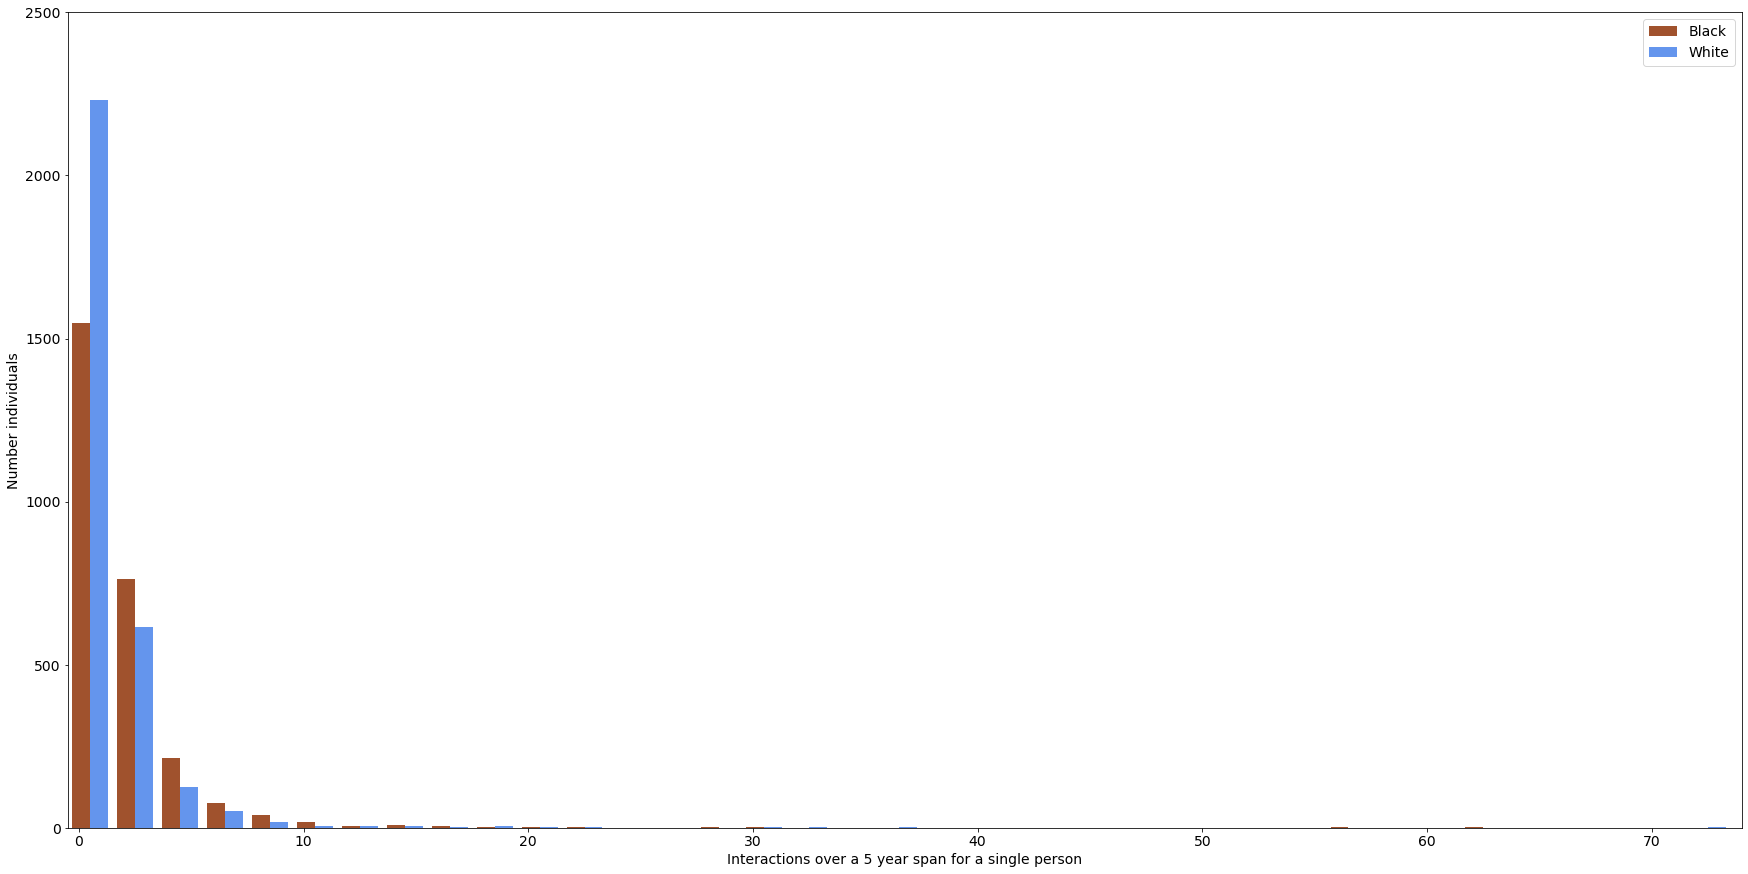

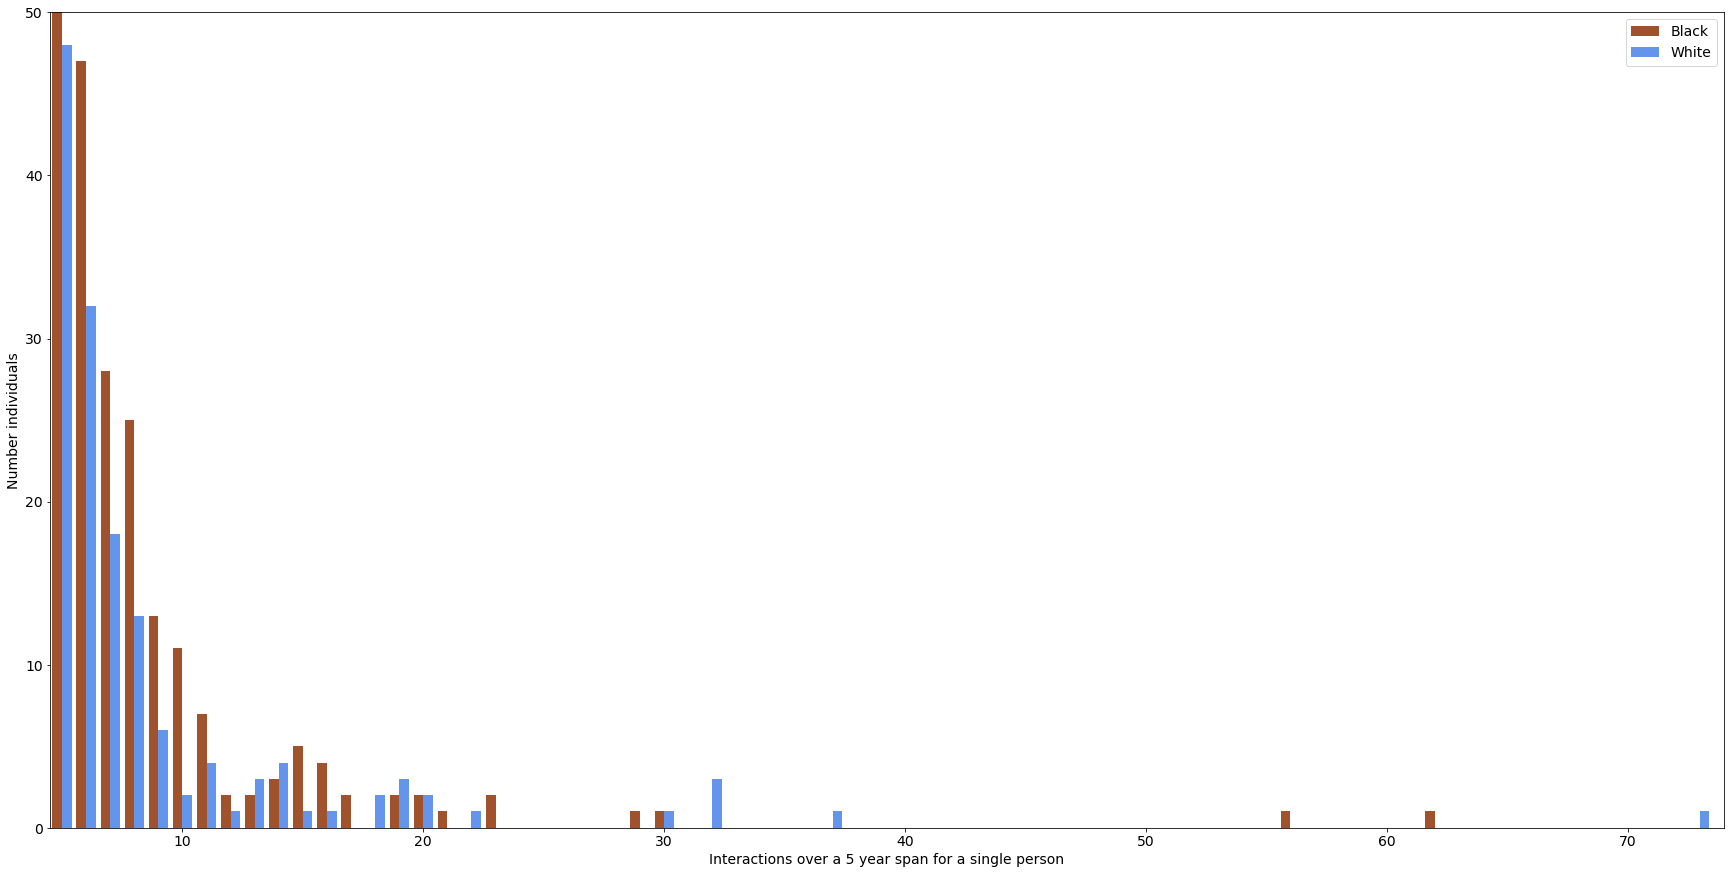

In [177]:
number_interactions  = []
interactions_race = []

# for each unique name, check how many unique name and date combos exist as each unique name_date is an interaction with the cops

for allpeople in arrests.fullname.unique():
    one_person = arrests[arrests.fullname == allpeople]
    number_interactions.append(len(one_person.name_and_date.unique()))
    interactions_race.append(one_person.Race.values[0])
    
    
black = np.where(np.array(interactions_race) == 'Black')
white = np.where(np.array(interactions_race) == 'White')
number_interactions = np.array(number_interactions)   
                               
bins = np.arange(0, number_interactions.max() + 1.5, step=2) - 0.5



plt.figure(figsize=(30,15))
plt.hist([number_interactions[black], number_interactions[white]], bins=bins, label=['Black', 'White'], color=['sienna', 'cornflowerblue'])
plt.xlim(-0.5,np.max(number_interactions)+1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Interactions over a 5 year span for a single person', fontsize=14)
plt.ylabel('Number individuals', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,2500)
plt.show()


# because there are a lot of people who only interact with the cops once or twice in year, redraw everything to see those folks who have the most interactions


rebin = np.arange(0, number_interactions.max() +1.5) -0.5

plt.figure(figsize=(30,15))
plt.hist([number_interactions[black], number_interactions[white]], bins=rebin, label=['Black', 'White'], color=['sienna', 'cornflowerblue'])
plt.xlim(4.5,np.max(number_interactions)+1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Interactions over a 5 year span for a single person', fontsize=14)
plt.ylabel('Number individuals', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,50)
plt.show()

In [49]:
# immediately work on reducing this from charges to unique arrests and locations

arrests_mapping['name_and_date'] = arrests_mapping.FirstName.str.lower()+' '+arrests_mapping.MiddleName.str.lower()+' '+arrests_mapping.LastName+' '+arrests_mapping.rounded_datetime





arrests_mapping.HouseNumber = pd.to_numeric(arrests_mapping.HouseNumber, errors='coerce')
arrests_mapping = arrests_mapping.dropna(axis=0, subset=['HouseNumber'])
arrests_mapping.HouseNumber = arrests_mapping.HouseNumber.astype('int')


arrests_mapping['address'] = arrests_mapping['HouseNumber'].astype('str')+' '+arrests_mapping['Street']+", Charlottesville, VA"
arrests_mapping['rounded_address'] = ((arrests_mapping['HouseNumber']/100.).astype(int) * 100).astype(str)+' '+arrests_mapping['Street']


arrests['StatuteDescription'] =arrests['StatuteDescription'].str.lower()
#print (arrests_mod)


arrests.loc[arrests['rounded_address'].str.contains('1600 AVON ST'), 'rounded_address'] = '100 PEREGORY LN'
address_counts = arrests.rounded_address.value_counts()
address_counts = address_counts.to_dict()

address_values = np.array(list(address_counts.values()))
blockaddress_names = np.array(list(address_counts.keys()))



result = usaddress.parse(arrests.rounded_address[0])
goddamn = dict(result)


new_dict = dict (zip(goddamn.values(),goddamn.keys()))


print (result, goddamn, new_dict)

14613
